STEP 1: Pre-Processing Starter Notebook


In [1]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
# Define directories
train_dir = '/kaggle/input/bttai-nybg-2024/BTTAIxNYBG-train/BTTAIxNYBG-train'
test_dir = '/kaggle/input/bttai-nybg-2024/BTTAIxNYBG-test/BTTAIxNYBG-test'
validation_dir = '/kaggle/input/bttai-nybg-2024/BTTAIxNYBG-validation/BTTAIxNYBG-validation'

# Load datasets
train_df = pd.read_csv('/kaggle/input/bttai-nybg-2024/BTTAIxNYBG-train.csv')
test_df = pd.read_csv('/kaggle/input/bttai-nybg-2024/BTTAIxNYBG-test.csv')
validate_df = pd.read_csv('/kaggle/input/bttai-nybg-2024/BTTAIxNYBG-validation.csv')

# Data augmentation configuration for training
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1./255
)

# Note: No augmentation for validation and test data, only rescaling
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Convert dataframe to a format suitable for the model training
def df_to_dataset(dataframe, datagen, directory, batch_size=32):
    return datagen.flow_from_dataframe(
        dataframe=dataframe,
        directory=directory,
        x_col='imageFile',  # Column in dataframe that contains the filenames
        y_col='classLabel',  # Column in dataframe that contains the class/label
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical'  # Change this if not a multiclass classification
    )

# Create datasets for training, validation, and testing
train_dataset = df_to_dataset(train_df, train_datagen, train_dir)
validation_dataset = df_to_dataset(validate_df, validation_datagen, validation_dir)

# This setup is now ready for training with model.fit using the train_dataset and validation_dataset

2024-03-13 19:58:58.072409: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-13 19:58:58.072547: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-13 19:58:58.239492: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 81946 validated image filenames belonging to 10 classes.
Found 10244 validated image filenames belonging to 10 classes.


In [2]:
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Define your model with regularization
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3), kernel_regularizer=regularizers.l2(0.01)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(10, activation='softmax')
])

# Define optimizer with custom learning rate
initial_learning_rate = 0.001
opt = Adam(lr=initial_learning_rate)

# Compile the model
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define learning rate scheduler
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-7)

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True),
    lr_scheduler
]

# Reduce the number of epochs
epochs = 2

# Increase batch size
batch_size = 128

# Fitting the model with reduced epochs and increased batch size to see if accuracy goes up 
history = model.fit(
    train_dataset,  # Using the full training data
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=callbacks,
    batch_size=batch_size
)


Epoch 1/2


I0000 00:00:1710360901.146674     104 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2561/2561 [==============================] - ETA: 0s - loss: 1.5330 - accuracy: 0.6101

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2561/2561 [==============================] - 2790s 1s/step - loss: 1.5330 - accuracy: 0.6101 - val_loss: 1.3493 - val_accuracy: 0.6414 - lr: 0.0010
Epoch 2/2
2561/2561 [==============================] - 1887s 737ms/step - loss: 1.2321 - accuracy: 0.6690 - val_loss: 1.2541 - val_accuracy: 0.6596 - lr: 0.0010


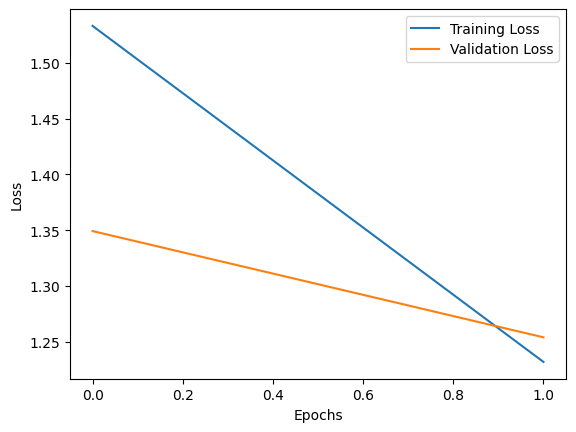

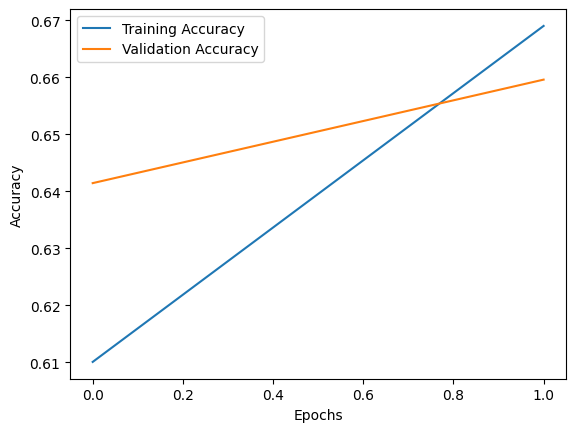

NameError: name 'test_dataset' is not defined

In [3]:
import matplotlib.pyplot as plt

# Visualize training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate model performance on test data
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

# Save the model
model.save('my_model.h5')
